In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

In [87]:
data = pd.read_csv("final.csv")

In [88]:
data = data[(data["Area"] > data["Area"].quantile(0.05)) & (data["Area"] <data["Area"].quantile(0.95))]
data["Area"].fillna(value=data["Area"].mean(), inplace=True)

In [89]:
data.columns

Index(['index', 'House Direction', 'Balcony Direction', 'Bedrooms', 'Toilets',
       'Legits', 'Floors', 'Facade', 'Entrance', 'District', 'Ward', 'Street',
       'Area', 'Price', 'X', 'Y'],
      dtype='object')

In [90]:
data["Price"] = data["Price"]/data["Area"]

In [91]:
data = data[['House Direction', 'Balcony Direction', 'Toilets','Bedrooms', 
       'Legits', 'Floors', 'Facade', 'Entrance', 'X', 'Y',
        'Price']]

In [92]:
data.head()

,House Direction,Balcony Direction,Toilets,Bedrooms,Legits,Floors,Facade,Entrance,X,Y,Price
0,None,None,6,6,+đỏ,6,5.1,30.0,21.024039,105.824232,350.000000
1,None,None,4,6,+đỏ,5,4.6,NaN,20.969225,105.774632,78.205128
2,None,None,3,4,+đỏ+hồng,4,5.0,NaN,20.969225,105.774632,129.166667
3,None,None,3,4,+đỏ,4,4.0,NaN,20.979725,105.790661,88.372093
4,None,None,4,3,+đỏ+hồng,5,4.0,2.5,21.011045,105.767012,114.285714


In [93]:
data = data[data["Price"] > data.Price.quantile(0.05)]
data = data[data["Price"] < data.Price.quantile(0.95)]
data.Price.describe()

count    28079.000000
mean      1026.074038
std        930.900554
min         55.111111
25%        171.428571
50%        878.378378
75%       1563.564214
max       3955.223881
Name: Price, dtype: float64

IQR = data.Price.quantile(0.75) - data.Price.quantile(0.25)
Lower_fence = data.Price.quantile(0.25) - (IQR * 3)
Upper_fence = data.Price.quantile(0.75) + (IQR * 3)

data = data[(data.Price >= Lower_fence) & (data.Price <= Upper_fence)]
data.Price.describe()

In [111]:
#hotdf = pd.get_dummies(data)
hotdf = data

In [112]:
hotdf.head()

,House Direction,Balcony Direction,Toilets,Bedrooms,Legits,Floors,Facade,Entrance,X,Y,Price
0,None,None,6,6,+đỏ,6,5.1,30.0,21.024039,105.824232,350.000000
1,None,None,4,6,+đỏ,5,4.6,3.0,20.969225,105.774632,78.205128
2,None,None,3,4,+đỏ+hồng,4,5.0,3.0,20.969225,105.774632,129.166667
3,None,None,3,4,+đỏ,4,4.0,3.0,20.979725,105.790661,88.372093
4,None,None,4,3,+đỏ+hồng,5,4.0,2.5,21.011045,105.767012,114.285714


In [113]:
hotdf.isnull().sum().sum()

0

In [114]:
hotdf["Entrance"][hotdf["Entrance"].isnull() ^ True].mode()

0    3.0
Name: Entrance, dtype: float64

In [115]:
hotdf["Entrance"].fillna(value=hotdf["Entrance"].mode().values[0], inplace=True)

In [116]:
cates = ["House Direction", "Balcony Direction",  "Toilets", "Legits", "Floors", "Bedrooms"]
for f in cates:
     hotdf[f] = hotdf[f].astype("category")


In [117]:
hotdf = pd.get_dummies(hotdf)

In [118]:
features = hotdf.columns.tolist()
features.remove("Price")

In [119]:
train, test = train_test_split(hotdf, test_size = 0.2)
train, dev = train_test_split(train, test_size = 0.1)

In [120]:
scaler = RobustScaler()
features_ = [
       'Facade', 'Entrance'
        ]
train[features_] = scaler.fit_transform(train[features_])

test[features_] = scaler.transform(test[features_])
dev[features_] = scaler.transform(dev[features_])

In [121]:
scaler = StandardScaler()
features_ = [
       'X', 'Y',
        ]
train[features_] = scaler.fit_transform(train[features_])
test[features_] = scaler.transform(test[features_])
dev[features_] = scaler.transform(dev[features_])

In [142]:
pca = PCA(n_components=10)

train_ = pca.fit_transform(train[features])

test_ = pca.transform(test[features])
dev_ = pca.transform(dev[features])

In [144]:
xgb = XGBRegressor(n_estimators = 300, max_depth=20, eta=0.01, gamma=1, tree_method="gpu_hist", subsample=1, objective="reg:squarederror", enable_categorical=True)

In [ ]:
xgb.fit(train[features], train["Price"], eval_set=[(dev[features], dev["Price"])], eval_metric="mape", early_stopping_rounds=20)

In [145]:
xgb.fit(train_, train["Price"], eval_set=[(dev_, dev["Price"])], eval_metric="mape", early_stopping_rounds=20)

C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mape:0.98594
[1]	validation_0-mape:0.97377
[2]	validation_0-mape:0.96178
[3]	validation_0-mape:0.94992
[4]	validation_0-mape:0.93829
[5]	validation_0-mape:0.92708
[6]	validation_0-mape:0.91611
[7]	validation_0-mape:0.90553
[8]	validation_0-mape:0.89519
[9]	validation_0-mape:0.88537
[10]	validation_0-mape:0.87628
[11]	validation_0-mape:0.86739
[12]	validation_0-mape:0.85882
[13]	validation_0-mape:0.85042
[14]	validation_0-mape:0.84220
[15]	validation_0-mape:0.83428
[16]	validation_0-mape:0.82651
[17]	validation_0-mape:0.81876
[18]	validation_0-mape:0.81114
[19]	validation_0-mape:0.80373
[20]	validation_0-mape:0.79625
[21]	validation_0-mape:0.78916
[22]	validation_0-mape:0.78212
[23]	validation_0-mape:0.77516
[24]	validation_0-mape:0.76807
[25]	validation_0-mape:0.76109
[26]	validation_0-mape:0.75434
[27]	validation_0-mape:0.74780
[28]	validation_0-mape:0.74127
[29]	validation_0-mape:0.73487
[30]	validation_0-mape:0.72883
[31]	validation_0-mape:0.72289
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eta=0.01, eval_metric=None,
             feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

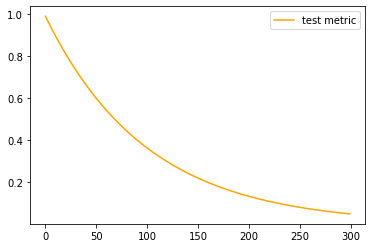

In [128]:
results = xgb.evals_result()
#plt.plot(results["validation_0"]["mape"], c= "b", label="train metric")
plt.plot(results["validation_0"]["mape"], c= "orange", label="test metric")
plt.legend()

In [53]:
pred = xgb.predict(test[features])
print(mape(test["Price"], pred))

0.4041376187765252


In [129]:
pred = xgb.predict(test)
print(mape(test["Price"], pred))

0.049044435988369106


(array([6.000e+00, 2.000e+01, 2.000e+01, 4.600e+01, 1.260e+02, 3.710e+02,
        2.509e+03, 1.130e+03, 5.120e+02, 2.140e+02, 1.440e+02, 7.000e+01,
        5.400e+01, 4.400e+01, 3.000e+01, 1.600e+01, 8.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00]),
 array([-2331.84977214, -1974.48183339, -1617.11389465, -1259.74595591,
         -902.37801717,  -545.01007843,  -187.64213969,   169.72579905,
          527.09373779,   884.46167653,  1241.82961528,  1599.19755402,
         1956.56549276,  2313.9334315 ,  2671.30137024,  3028.66930898,
         3386.03724772,  3743.40518646,  4100.7731252 ,  4458.14106394,
         4815.50900269]),
 <BarContainer object of 20 artists>)

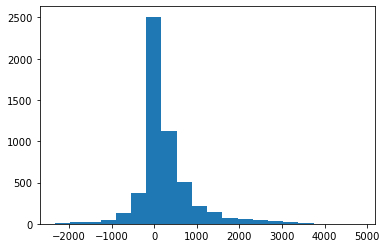

In [145]:
plt.hist(test["Price"].values-pred, bins=20)

In [39]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(pd.get_dummies(train[features]).values)

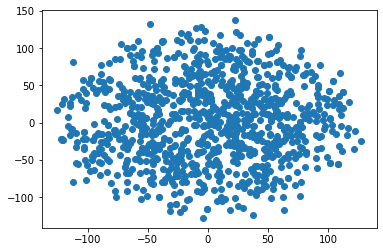

In [40]:
a, b = list(zip(*X_embedded))
plt.scatter(a[:1000],b[:1000])

(array([ 6088., 11138.,  5496.,  3396.,  1929.,  1215.,   697.,   575.,
          341.,   219.]),
 array([ 20.5 ,  38.35,  56.2 ,  74.05,  91.9 , 109.75, 127.6 , 145.45,
        163.3 , 181.15, 199.  ]),
 <BarContainer object of 10 artists>)

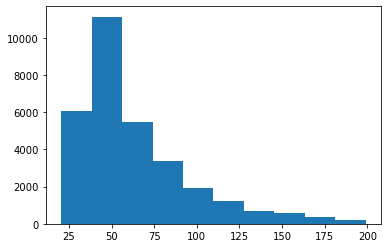

In [362]:
plt.hist(data["Area"][(data["Area"] > 20) & (data["Area"] <200)], bins=10)

In [363]:
data["Area"][(data["Area"] > 20) & (data["Area"] <200)]

0        80.0
1        78.0
2        48.0
3        43.0
4        35.0
         ... 
34951    54.0
34952    75.0
34953    40.0
34954    42.0
34955    50.0
Name: Area, Length: 31094, dtype: float64

<AxesSubplot:ylabel='Frequency'>

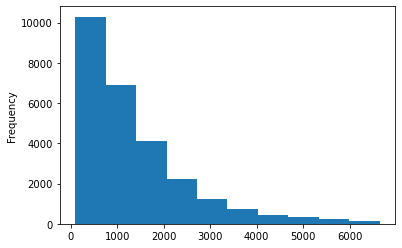

In [492]:
data["Price"].plot(kind="hist")

In [391]:
data[data["Price"] > 300000]

,House Direction,Balcony Direction,Bedrooms,Toilets,Legits,Floors,Facade,Entrance,District,Area,Price
13890,None,None,6,None,+đỏ+hồng,3,17.0,3.0,nam từ liêm,180.0,330000.0
13908,None,None,4,None,+đỏ+hồng,4,5.0,3.0,hoàn kiếm,130.0,330000.0
13931,None,None,10+,None,+đỏ+hồng,9,5.0,3.0,ba đình,89.0,320000.0
14000,None,None,8,None,None,8,5.0,3.0,đống đa,90.0,330000.0
14042,None,None,5,None,+đỏ+hồng,7,7.0,3.0,cầu giấy,120.0,324000.0
...,...,...,...,...,...,...,...,...,...,...,...
34836,None,None,5,None,+đỏ+hồng,5,30.0,3.0,cầu giấy,56.0,310000.0
34842,None,None,3,None,+đỏ+hồng,5,2.0,3.0,long biên,35.0,310000.0
34904,None,None,10+,None,+đỏ+hồng,8,8.0,3.0,cầu giấy,110.0,340000.0
34910,None,None,8,None,+đỏ+hồng,5,10.0,3.0,cầu giấy,100.0,320000.0


In [ ]:
data["Price"]/data["Area"]